In [2]:
# 注：All image samples are represented by four filters (stored as individual files), the protein of interest 
# (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). 
# The green filter should hence be used to predict the label, and the other filters are used as references.

# 每个id都有四张图，分别用不同的滤框表示： 蛋白质（绿）， 核（蓝色）， 微管（红色）， 内质网（黄色）

#### Node: 对函数传递的参数进行打包（成元组tuple或字典dictionary）和拆解（分解成单个元素），其中元组的打包和解包使用单星号‘*’，字典的打包和拆解使用’**’。 

In [3]:
INPUT_FILE = '../data/'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
from tqdm import trange, tqdm

In [9]:
train_csv = pd.read_csv(f"{INPUT_FILE}train.csv")
train_csv.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [10]:
train_csv.shape

(31072, 2)

In [11]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [12]:
for key in label_names.keys():
    train_csv[label_names[key]] = 0

In [13]:
def fill_target(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        row.loc[label_names[int(num)]] = 1
    return row

In [14]:
train_csv = train_csv.apply(fill_target, axis=1)
train_csv.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns

label_counts = train_csv.sum(axis=0)

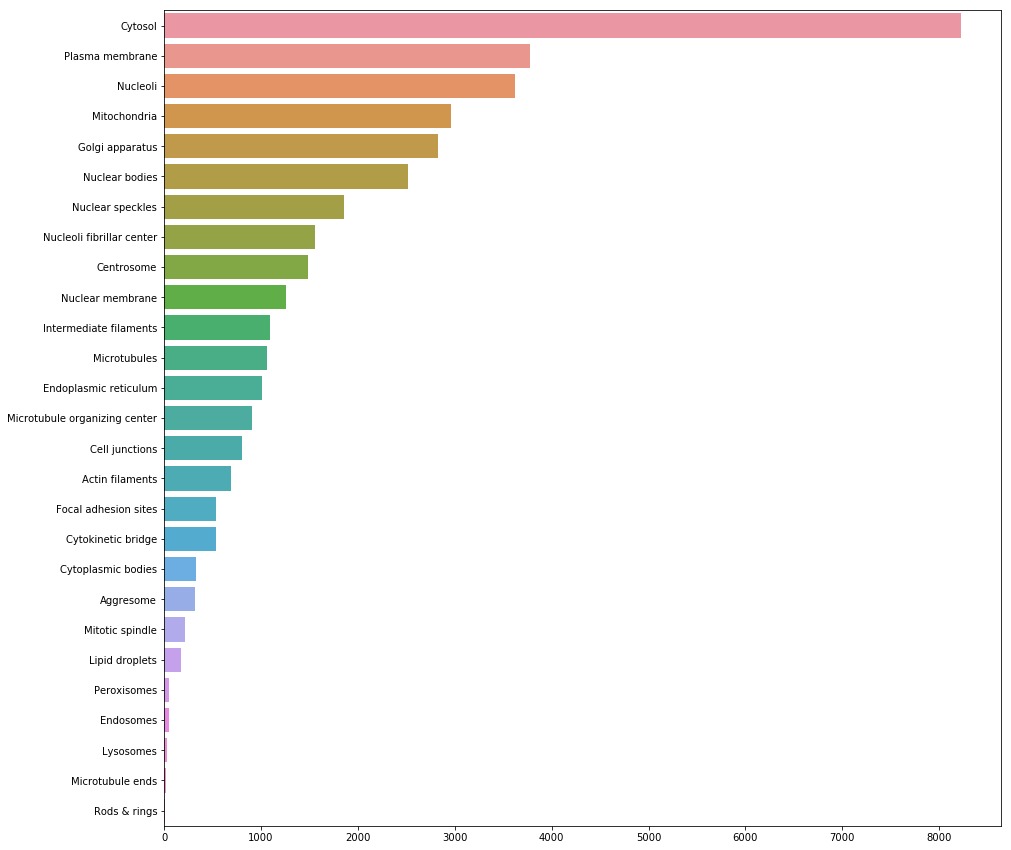

In [16]:
target_counts = label_counts[1:].sort_values(ascending=False)
plt.figure(figsize=(15, 15))
sns.barplot(y=target_counts[1:].index.values, x=target_counts[1:].values, order=target_counts[1:].index)

In [17]:
label_counts[1:].sort_values()

Rods & rings                        11
Microtubule ends                    21
Lysosomes                           28
Endosomes                           45
Peroxisomes                         53
Lipid droplets                     172
Mitotic spindle                    210
Aggresome                          322
Cytoplasmic bodies                 328
Cytokinetic bridge                 530
Focal adhesion sites               537
Actin filaments                    688
Cell junctions                     802
Microtubule organizing center      902
Endoplasmic reticulum             1008
Microtubules                      1066
Intermediate filaments            1093
Nuclear membrane                  1254
Centrosome                        1482
Nucleoli fibrillar center         1561
Nuclear speckles                  1858
Nuclear bodies                    2513
Golgi apparatus                   2822
Mitochondria                      2965
Nucleoli                          3621
Plasma membrane          

In [18]:
train_csv["number_of_targets"] = train_csv.drop(['Id', 'Target'], axis=1).sum(axis=1)
count_perc = np.round(100 * train_csv["number_of_targets"].value_counts() / train_csv.shape[0], 2)

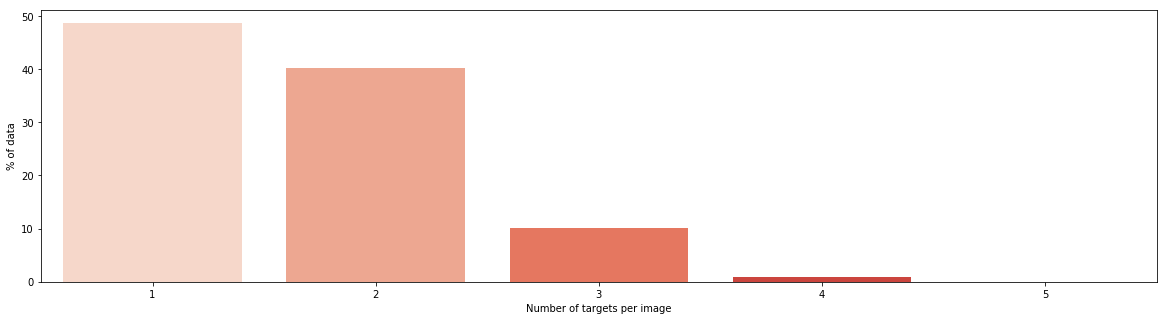

In [19]:
plt.figure(figsize=(20, 5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette='Reds')
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

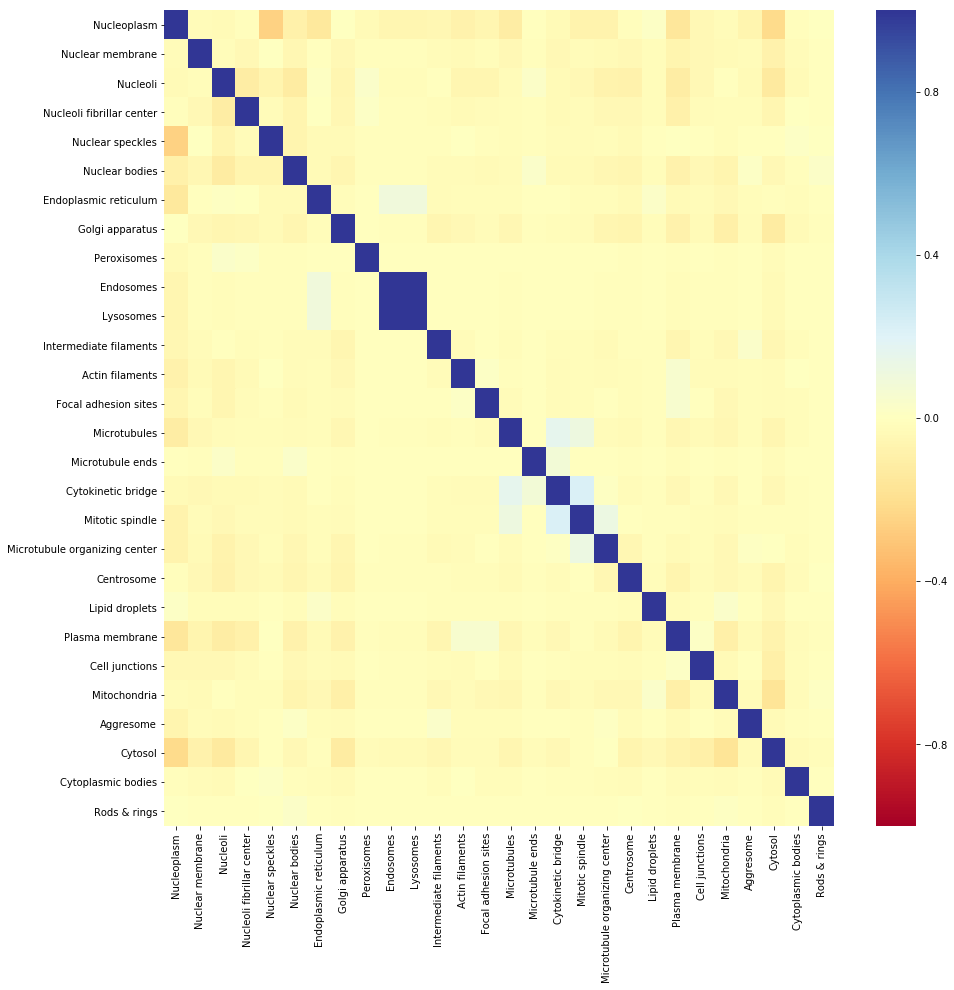

In [20]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_csv[train_csv.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"], axis=1).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

In [21]:
def find_counts(target_name, dataFrame):
    counts = dataFrame[dataFrame[target_name]==1].drop(["Id", "Target", "number_of_targets"], axis=1).sum(axis=0)
    counts = counts[counts>0]
    counts = counts.sort_values()
    return counts

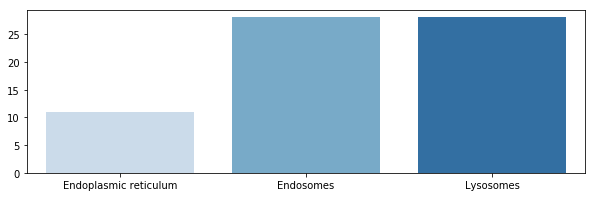

In [22]:
lyso_endo_counts = find_counts("Lysosomes", train_csv)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

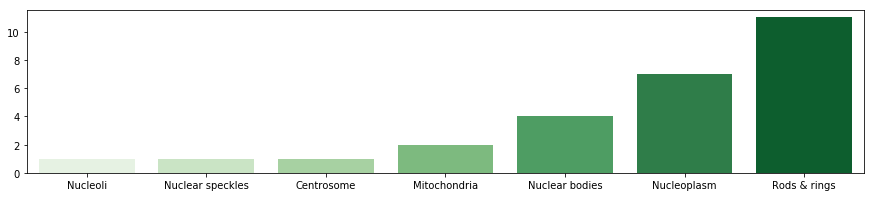

In [23]:
rod_rings_counts = find_counts("Rods & rings", train_csv)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

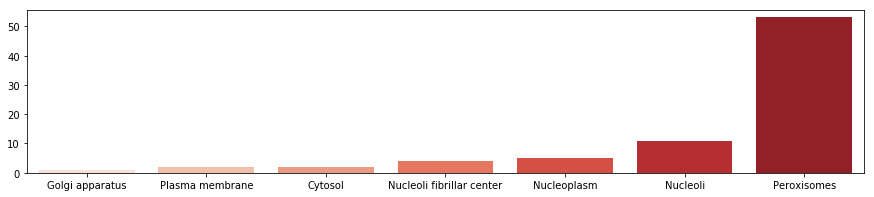

In [24]:
peroxi_counts = find_counts("Peroxisomes", train_csv)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

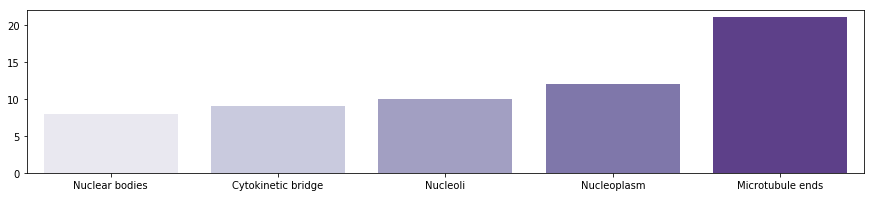

In [25]:
tubeends_counts = find_counts("Microtubule ends", train_csv)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

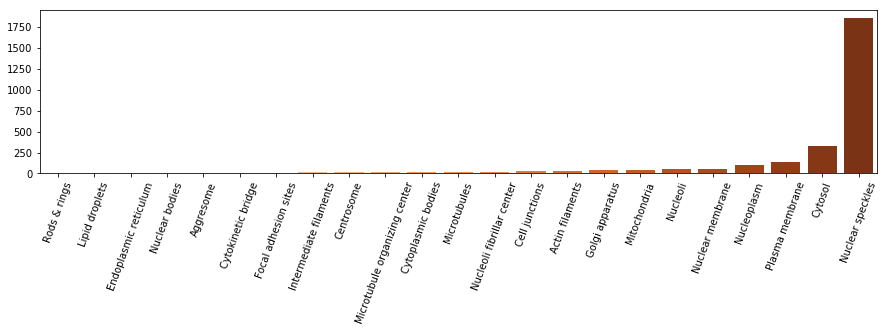

In [26]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_csv)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

In [27]:
import glob
import os

# img_file = glob.glob(f"{INPUT_FILE}train/*.png")
img_file = os.listdir(f"{INPUT_FILE}train")
train_img_file = os.listdir(f"{INPUT_FILE}train")
test_img_file = os.listdir(f"{INPUT_FILE}test")

num_train = len(train_img_file) // 4
num_test = len(test_img_file) // 4

print(f"number of train img: {num_train} \n"
     f"number of test img: {num_test}")

number of train img: 31072 
number of test img: 11702


In [28]:
# a green filter for the target protein structure of interest
# blue landmark filter for the nucleus
# red landmark filter for microtubules
# yellow landmark filter for the endoplasmatic reticulum

# Each image is of size 512 x 512

In [29]:
def load_image(image_id, dataset="train"):
    images = np.zeros((4, 512, 512))
    images[0,...] = plt.imread(f"{INPUT_FILE}{dataset}/{image_id}_green.png")
    images[1,...] = plt.imread(f"{INPUT_FILE}{dataset}/{image_id}_red.png")
    images[2,...] = plt.imread(f"{INPUT_FILE}{dataset}/{image_id}_blue.png")
    images[3,...] = plt.imread(f"{INPUT_FILE}{dataset}/{image_id}_yellow.png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[0].set_title(title)
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    return subax

def make_title(file_id):
    file_targets = train_csv.loc[train_csv["Id"] == file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [30]:
# reverse train labels
reverse_train_csv = dict((v, k) for k,v in label_names.items())

In [31]:
class TargetGroupIterator:
    def __init__(self, target_names, batch_size, datasets="train"):
        self.target_names = target_names
        self.target_list = [reverse_train_csv[key] for key in target_names]
        self.batch_size = batch_size
        self.datasets = datasets
        self.batch_shape = (batch_size, 4, 512, 512)
    
    def find_matching_data_entries(self):
        train_csv["check_col"] = train_csv.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_csv[train_csv.check_col==1].Id.values
        train_csv.drop("check_col", axis=1, inplace=True)
        
    def check_subset(self, targets):
        return np.where(set(self.target_list).issuperset(set(targets)), 1, 0)
    
    def get_loader(self):
        filename = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx, ...] = load_image(image_id, self.datasets)
            filename.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filename, images
                filename = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filename, images

In [32]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 3

In [33]:
imageloader = TargetGroupIterator(your_choice, your_batch_size)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

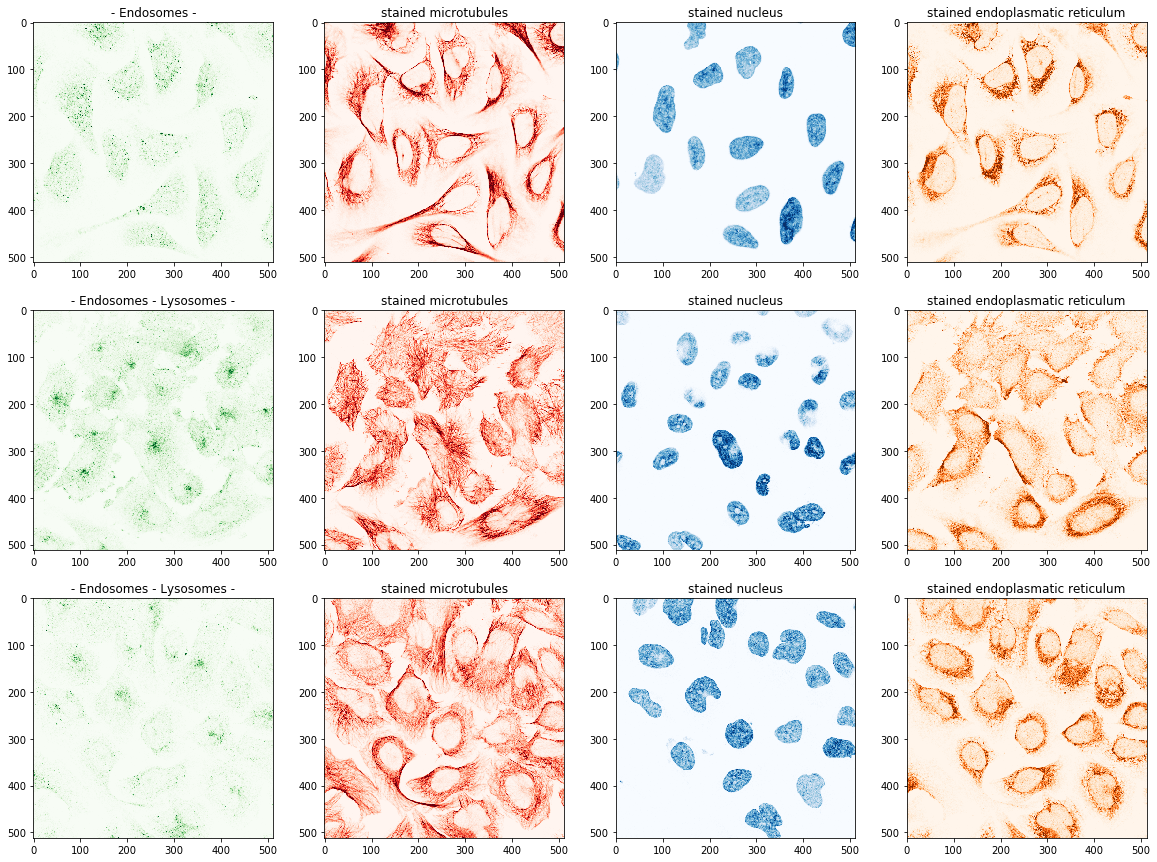

In [34]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

In [70]:
from sklearn import model_selection

rkf = model_selection.RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

partitions = []
for train_idx, test_idx in rkf.split(train_csv[1:5000].index.values):
    partition = {}
    partition["train"] = train_csv.Id.values[train_idx]
    partition["validation"] = train_csv.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [   0    2    3 ..., 4996 4997 4998] TEST: [   1    9   12 ..., 4993 4994 4995]
TRAIN: 3332 TEST: 1667
TRAIN: [   0    1    7 ..., 4995 4996 4997] TEST: [   2    3    4 ..., 4987 4989 4998]
TRAIN: 3333 TEST: 1666
TRAIN: [   1    2    3 ..., 4994 4995 4998] TEST: [   0    7   16 ..., 4991 4996 4997]
TRAIN: 3333 TEST: 1666


## model

In [124]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf


In [134]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [85]:
class ModelParameter:
    def __init__(self, dataset="train", 
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=100, # 200
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=5,
                 log_dir="./logs"):
        self.dataset = dataset
        self.basepath = f"{INPUT_FILE}{dataset}/"
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs
        self.log_dir = log_dir

In [86]:
parameter = ModelParameter()

In [87]:
from skimage import transform
class ImagePreprocessor:
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = transform.resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = plt.imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = plt.imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = plt.imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = plt.imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]

In [88]:
preprocessor = ImagePreprocessor(parameter)

(512, 512)
(128, 128, 1)


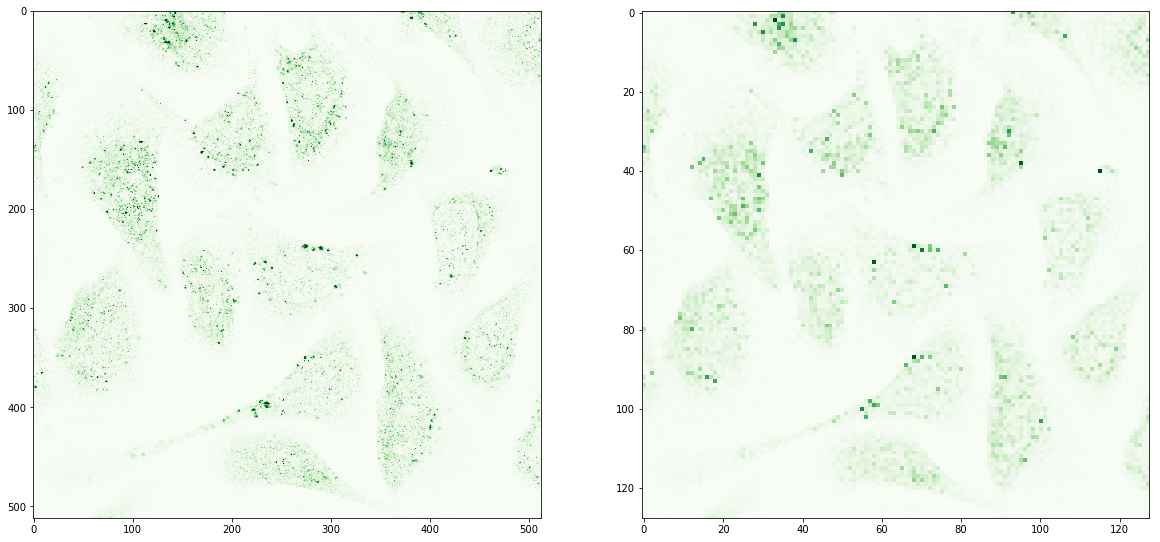

In [89]:
example = images[0,0]
preprocessed = preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(parameter.scaled_row_dim,parameter.scaled_col_dim), cmap="Greens")

In [90]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor):
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.preprocessor = imagepreprocessor
        self.batch_size = self.params.batch_size
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.n_channels = self.params.n_channels
        self.shuffle = self.params.shuffle
        self.num_classes = self.params.num_classes
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                    ["Id", "Target", "number_of_targets"], axis=1).values
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty([self.batch_size, *self.dim, self.n_channels])
        y = np.empty([self.batch_size, self.num_classes])
        # Generate Data
        for i, identifier in enumerate(list_IDs_temp):
            # Store sample
            image = self.preprocessor.load_image(identifier)
            image = self.preprocessor.preprocess(image)
            X[i] = image
            # Store class
            y[i] = self.get_targets_per_image(identifier)
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs)/ self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

In [91]:
class PredictGenerator:
    def __init__(self, predict_Ids, imagepreprocessor, predict_path):
        self.preprocessor = imagepreprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_Ids
    
    def predict(self, model):
        y = np.empty([len(self.identifiers), self.preprocessor.parameter.num_classes])
        for n in trange(len(self.identifiers)):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

### CNN Baseline model using keras

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, Adam
from keras.models import load_model
from keras.callbacks import TensorBoard

class BaseLineModel:
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
        self.log_dir = self.params.log_dir
        self.tbCallBack = TensorBoard(log_dir=self.log_dir,
                                     histogram_freq=0,
                                     batch_size=32,
                                     write_graph=True,
                                     write_grads=True,
                                     write_images=True,
                                     embeddings_freq=0,
                                     embeddings_layer_names=None,
                                     embeddings_metadata=None)
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
    
    def compile_model(self):
        self.model.compile(loss=binary_crossentropy,
                optimizer=Adadelta(),
                metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.train_generator = train_generator
        self.validation_generator = validation_generator
    
    def train(self):
        return self.model.fit_generator(generator=self.train_generator,
                                        validation_data=self.validation_generator,
                                        epochs=self.params.n_epochs,
                                        use_multiprocessing=False,
                                        callbacks=[self.tbCallBack]
                                        )
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                            use_multiprocessing=False,
                                            )
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [93]:
# Datasets
partition = partitions[0]
labels = train_csv

print("Number of samples in train: {}".format(len(partition["train"])))
print("Number of samples in validation: {}".format(len(partition["validation"])))

Number of samples in train: 3332
Number of samples in validation: 1667


In [111]:
train_path = f"{INPUT_FILE}train/"
test_path = f"{INPUT_FILE}test/"

In [103]:
test_csv = pd.read_csv(f"{INPUT_FILE}sample_submission.csv")

In [109]:
test_Ids_list = list(test_csv.Id.values)

In [115]:
train_genrator = DataGenerator(partition['train'], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'], labels, parameter, preprocessor)
predict_generator = PredictGenerator(test_Ids_list, preprocessor, test_path)

In [96]:
class KernelSettings:
    
    def __init__(self, fit_baseline=False, fit_improved_baseline=False):
        self.fit_baseline = fit_baseline
        self.fit_improved_baseline = fit_improved_baseline

In [97]:
kernelsettings = KernelSettings(fit_baseline=True, fit_improved_baseline=False)

In [98]:
if kernelsettings.fit_baseline == True:
    model = BaseLineModel(parameter)
    model.build_model()
    model.compile_model()
    model.set_generators(train_genrator, validation_generator)
    history = model.train()
    proba_predictions = model.predict(predict_generator)
    baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_csv.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
    baseline_proba_predictions.to_csv("baseline_predictions.csv")
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    baseline_proba_predictions = pd.read_csv("../input/protein-atlas-eab-predictions/baseline_predictions.csv", index_col=0)

Epoch 1/5
33/33 [==============================] - ETA: 6:37 - loss: 0.6931 - acc: 0.542 - ETA: 5:52 - loss: 0.6924 - acc: 0.672 - ETA: 5:22 - loss: 0.6909 - acc: 0.707 - ETA: 5:05 - loss: 0.6873 - acc: 0.726 - ETA: 4:54 - loss: 0.6793 - acc: 0.735 - ETA: 4:41 - loss: 0.6642 - acc: 0.740 - ETA: 4:29 - loss: 0.6427 - acc: 0.745 - ETA: 4:19 - loss: 0.6177 - acc: 0.752 - ETA: 4:08 - loss: 0.5957 - acc: 0.759 - ETA: 3:56 - loss: 0.5756 - acc: 0.766 - ETA: 3:45 - loss: 0.5578 - acc: 0.773 - ETA: 3:30 - loss: 0.5405 - acc: 0.780 - ETA: 3:16 - loss: 0.5248 - acc: 0.787 - ETA: 3:03 - loss: 0.5108 - acc: 0.793 - ETA: 2:50 - loss: 0.4980 - acc: 0.800 - ETA: 2:39 - loss: 0.4857 - acc: 0.805 - ETA: 2:27 - loss: 0.4743 - acc: 0.811 - ETA: 2:17 - loss: 0.4640 - acc: 0.816 - ETA: 2:06 - loss: 0.4550 - acc: 0.820 - ETA: 1:56 - loss: 0.4454 - acc: 0.825 - ETA: 1:46 - loss: 0.4379 - acc: 0.828 - ETA: 1:37 - loss: 0.4298 - acc: 0.832 - ETA: 1:27 - loss: 0.4225 - acc: 0.836 - ETA: 1:18 - loss: 0.4156 - ac

In [117]:
proba_predictions = model.predict(predict_generator)

## Full validation

In [118]:
?load_model

In [119]:
proba_predictions

array([[ 0.40461943,  0.03007825,  0.09647864, ...,  0.2567161 ,
         0.01422664,  0.00463431],
       [ 0.40462279,  0.03008568,  0.0964992 , ...,  0.2567277 ,
         0.01423134,  0.00463646],
       [ 0.40416658,  0.0295887 ,  0.09555025, ...,  0.25574949,
         0.01394168,  0.00451588],
       ..., 
       [ 0.40465254,  0.03012065,  0.09656607, ...,  0.25679848,
         0.01425093,  0.00464473],
       [ 0.40460929,  0.03007111,  0.09646979, ...,  0.25670061,
         0.01422192,  0.00463245],
       [ 0.40464488,  0.03010554,  0.09653473, ...,  0.256767  ,
         0.01424148,  0.00464078]])

In [121]:
from keras.layers import deserialize

In [122]:
?deserialize

In [131]:
a = tf.zeros_like(4)

0